In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
from ultralytics import YOLO



### Use cuda if possible

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda


# 1

### 1.1

Transform input shape to fit dataloader, transform mask to ignore contour

In [3]:
input_dim = (200, 200)
transform = transforms.Compose([
    transforms.Resize(input_dim),  
    transforms.ToTensor(), 
])

def mask_transform(mask):
    mask = mask.resize(input_dim)  # Resize the mask to match the input image size
    mask = np.array(mask)  
    mask[mask == 3] = 1 # replace contour with pet class
    mask = mask - 1 # [1, 2] -> [0, 1] for softmax
    
    mask = torch.tensor(mask, dtype=torch.int64)  
    return mask


Custom dataset class for OxfordIIITPet Dataset:

In [4]:
def getBoundingBox(segmentation_mask):
    if isinstance(segmentation_mask, torch.Tensor):
        segmentation_mask = segmentation_mask.cpu().numpy()
        
    pet_pixels = np.argwhere(segmentation_mask == 0)
    
    if pet_pixels.size == 0:
        # Return a default bounding box if no object is found
        return torch.tensor([0, 0, 0, 0])
    
    
    ymin, xmin = np.min(pet_pixels, axis=0)
    ymax, xmax = np.max(pet_pixels, axis=0)
    
    return torch.tensor([xmin, ymin, xmax, ymax])

# dataset class
class CustomOxfordIIITPetDataset(torch.utils.data.Dataset):
    def __init__(self, image_root, mask_root, split='trainval', transform=None, mask_transform=None):
        self.image_dataset = OxfordIIITPet(
            root=image_root, 
            split=split, 
            target_types="segmentation", 
            download=True, 
            transform=transform, 
            target_transform=mask_transform
        )
        
        self.label_dataset = OxfordIIITPet(
            root=mask_root, 
            split=split, 
            target_types="binary-category", 
            download=True, 
            transform=transform
        )
    
    def __len__(self):
        return len(self.image_dataset)
    
    def __getitem__(self, idx):
        image, mask = self.image_dataset[idx]
        mask = np.array(mask)
#         mask[mask == 3] = 2 # Change contour to pet
        
        # get label
        _, label = self.label_dataset[idx]
        
        # get bounding box
        bounding_box = getBoundingBox(mask)
        
        return image, torch.tensor(mask, dtype=torch.long), label, bounding_box

### 1.2

### Instantiate custom dataset:

In [5]:
dataset = CustomOxfordIIITPetDataset(
    image_root='./oxfordiiitpet', 
    mask_root='./oxfordiiitpet_label', 
    split='trainval', 
    transform=transform, 
    mask_transform=mask_transform
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# train_batch = next(iter(train_loader))
# images, masks, labels, bounding_box = train_batch
# print("Batch image shape:", images.shape)
# print("Batch mask shape:", masks.shape)
# print("Batch labels shape:", labels.shape)
# print("Mask values: ", torch.unique(masks))
# print("Bounding_box: ", bounding_box)


Testing dataset loader

In [6]:
test_dataset = CustomOxfordIIITPetDataset(
    image_root='./oxfordiiitpet', 
    mask_root='./oxfordiiitpet_label', 
    split='test', 
    transform=transform, 
    mask_transform=mask_transform
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Test if dataloader outputs correct values

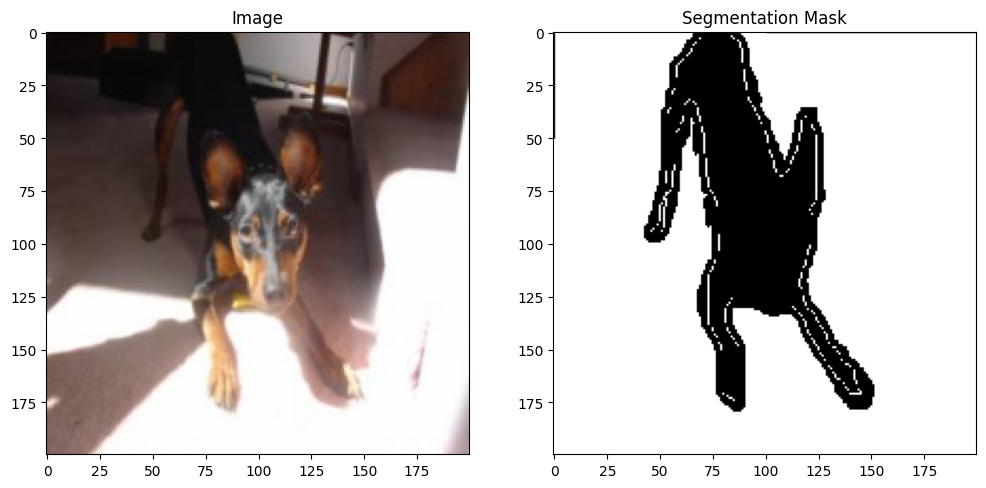

Image shape: torch.Size([3, 200, 200])
Mask shape: torch.Size([200, 200])
Label: 1
Bounding box coord: tensor([  0,   0, 199, 179])


In [7]:
# Display one image and its corresponding segmentation mask
for images, mask, label, bounding_box in train_loader:
    img = images[0]
    mask = mask[0]

    # Display the image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img.permute(1, 2, 0))  
    plt.title("Image")

    # Display the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray") 
    plt.title("Segmentation Mask")
    
    plt.show()
    
    print(f"Image shape: {img.shape}")
    print(f"Mask shape: {mask.shape}")
    print(f"Label: {label[0]}")
    print(f"Bounding box coord: {bounding_box[0]}")
    break  # Display only one batch

### 1.3

FCN implementation

In [8]:
# defining out CNN

class FCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # (in_channels, out_channels, kernel_size, stride, padding)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),  # (in_channels, out_channels, kernel_size, padding)
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
        )
        
        self.final_conv = nn.Conv2d(64, 2, kernel_size=3, padding=1)
#         self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.final_conv(x)
        
        return x


Training and validation loop functions

In [9]:
def calculate_iou(pred_mask, true_mask, num_classes=2):
    ious = []
    pred_mask = pred_mask.view(-1)
    true_mask = true_mask.view(-1)
    
    for cls in range(num_classes):
        intersection = torch.sum((pred_mask == cls) & (true_mask == cls)).item()
        union = torch.sum((pred_mask == cls) | (true_mask == cls)).item()
        if union == 0:
            ious.append(float('nan'))  
        else:
            iou = intersection / union
            ious.append(iou)
    
    return np.nanmean(ious)  


def train_model(model, train_loader, val_loader, num_epochs=6, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    iou_scores = []
    last_val_images = None
    last_val_masks = None
    last_val_preds = None
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks, _, _ in train_loader:
            images, masks = images.to(device), masks.to(device).long()
            
            # Zero grad
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(images)
            
            # compute loss
            loss = criterion(outputs, masks) 
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
    
        # eval on validation set
        model.eval()
        val_running_loss = 0.0
        iou_epoch = 0
        all_val_images = []
        all_val_masks = []
        all_val_preds = []
        
        with torch.no_grad():
            for images, masks, _, _ in val_loader:
                images, masks = images.to(device), masks.to(device).long()
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_running_loss += loss.item()
                
                predicted_masks = torch.argmax(outputs, dim=1)
                iou = calculate_iou(predicted_masks, masks)
                iou_epoch += iou
                
                # Store images, masks, and predicted masks from the last epoch for printing
                all_val_images.append(images.cpu())
                all_val_masks.append(masks.cpu())
                all_val_preds.append(predicted_masks.cpu())
                
        val_losses.append(val_running_loss / len(val_loader))
        iou_scores.append(iou_epoch / len(val_loader))
        
        print(f"Epoch [{epoch + 1}/{num_epochs}] \n  Train Loss: {train_losses[-1]:.4f}\n  Val Loss: {val_losses[-1]:.4f}\n  Mean IoU: {iou_scores[-1]:.4f}")
        
        # If it's the last epoch, store the images, masks, and predictions for visualization
        if epoch == num_epochs - 1:
            last_val_images = torch.cat(all_val_images, dim=0)
            last_val_masks = torch.cat(all_val_masks, dim=0)
            last_val_preds = torch.cat(all_val_preds, dim=0)
        
    # plot loss and IoU
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(iou_scores, label="Mean IoU")
    plt.xlabel("Epoch")
    plt.ylabel("Mean IoU")
    plt.legend()

    plt.show()
    
    # Display 3 images, their true masks, and predicted masks from the last validation epoch
    if last_val_images is not None and last_val_masks is not None and last_val_preds is not None:
        num_images_to_show = 3
        for i in range(num_images_to_show):
            plt.figure(figsize=(15, 5))
            
            # Original image
            plt.subplot(1, 3, 1)
            plt.imshow(last_val_images[i].permute(1, 2, 0)) 
            plt.title("Image")
            
            # Ground truth mask
            plt.subplot(1, 3, 2)
            plt.imshow(last_val_masks[i], cmap='gray')
            plt.title("Ground Truth Mask")
            
            # Predicted mask
            plt.subplot(1, 3, 3)
            plt.imshow(last_val_preds[i], cmap='gray')
            plt.title("Predicted Mask")
            
            plt.show()


Testing loop on test data

In [10]:

def test_model(model, test_loader, num_classes=2):
    model = model.to(device)
    model.eval() 
    criterion = nn.CrossEntropyLoss()  
    
    running_loss = 0.0
    iou_scores = []
    
    with torch.no_grad(): 
        for images, masks, _, _ in test_loader:
            images, masks = images.to(device), masks.to(device).long()
            
            # Forward pass
            outputs = model(images)
            
            # Compute test loss
            loss = criterion(outputs, masks)
            running_loss += loss.item()
            
            predicted_masks = torch.argmax(outputs, dim=1)
            
            # compute IoU for each image in the batch
            for i in range(images.size(0)):  
                true_mask = masks[i]
                pred_mask = predicted_masks[i]
                

                iou = calculate_iou(pred_mask, true_mask, num_classes=num_classes)
                iou_scores.append(iou)
    
    # Compute average loss and mean IoU
    test_loss = running_loss / len(test_loader)
    mean_iou = np.nanmean(iou_scores)  
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")
    
    return test_loss, mean_iou


Run training, valildation, and finally testing loop on FCN model.

Epoch [1/6] 
  Train Loss: 0.6610
  Val Loss: 0.6524
  Mean IoU: 0.2958
Epoch [2/6] 
  Train Loss: 0.5957
  Val Loss: 0.6102
  Mean IoU: 0.5295
Epoch [3/6] 
  Train Loss: 0.5592
  Val Loss: 0.5249
  Mean IoU: 0.5841
Epoch [4/6] 
  Train Loss: 0.5077
  Val Loss: 0.5034
  Mean IoU: 0.6087
Epoch [5/6] 
  Train Loss: 0.4806
  Val Loss: 0.4998
  Mean IoU: 0.6166
Epoch [6/6] 
  Train Loss: 0.4770
  Val Loss: 0.4929
  Mean IoU: 0.6191


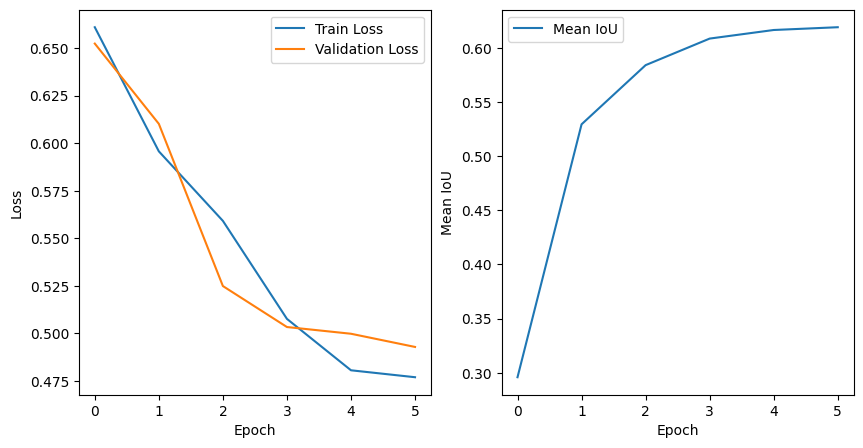

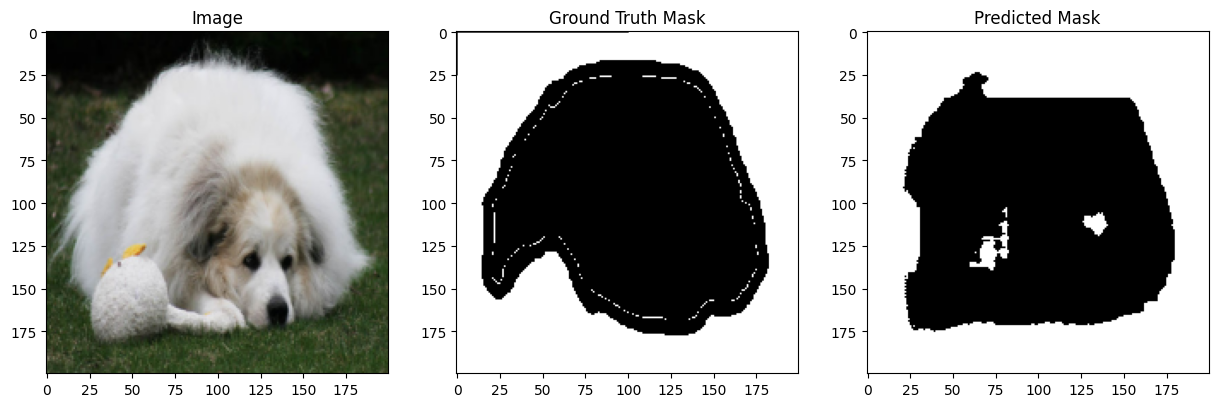

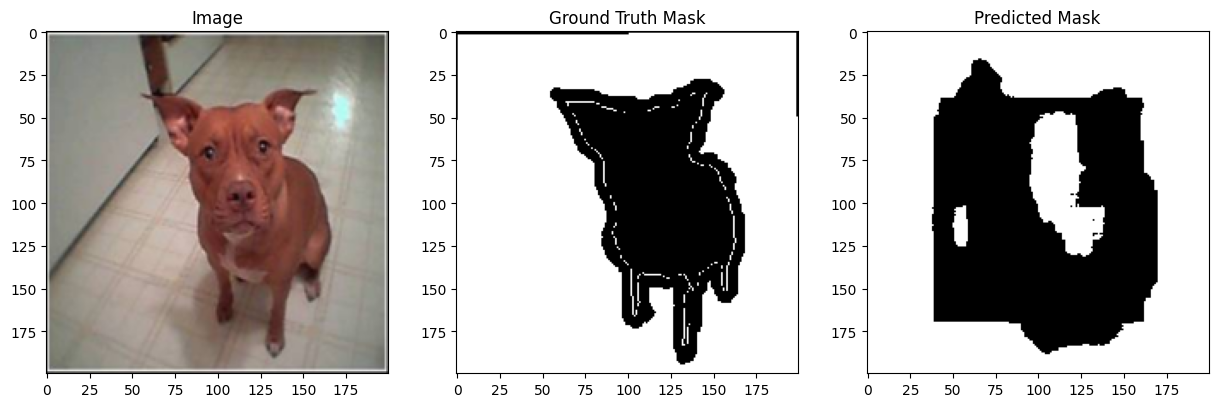

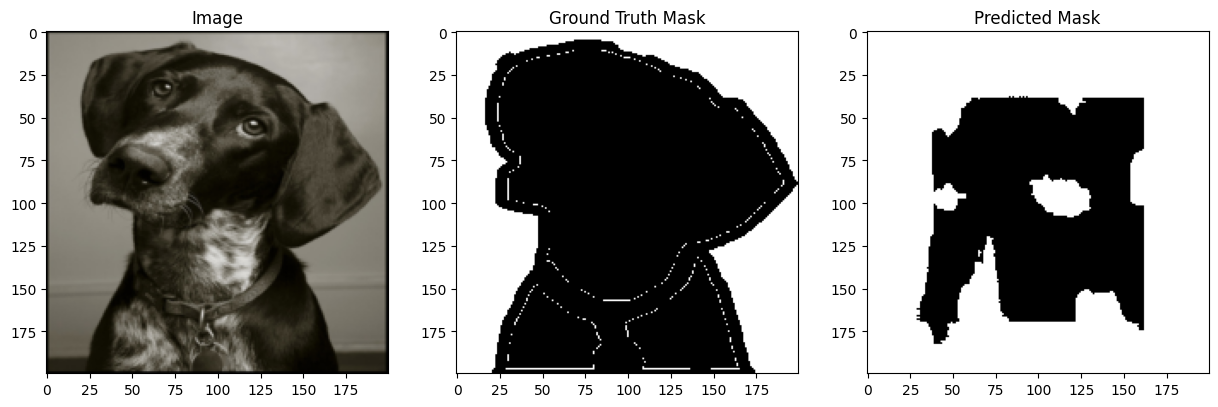

Test Loss: 0.4903
Mean IoU: 0.6211


In [11]:
fcnModel = FCN()
trained_model = train_model(fcnModel, train_loader, val_loader)
tested_model = test_model(fcnModel, test_loader)

### 1.4

UNet implementation

In [12]:

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        # Decoder
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        # Final Output Layer
        self.final_conv = nn.Conv2d(64, 2, kernel_size=1)
        
    def forward(self, x):
        # Encoder with skip connections
        enc1 = self.enc1(x)       
        enc2 = self.enc2(enc1)    
        enc3 = self.enc3(enc2)    
        
        # Bottleneck
        bottleneck = self.bottleneck(enc3)
        
        # Decoder with skip connections and cropping
        dec3 = self.upconv3(bottleneck)
        dec3 = self._center_crop(dec3, enc3.size()[2:])  
        dec3 = torch.cat((enc3, dec3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = self._center_crop(dec2, enc2.size()[2:])  
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = self._center_crop(dec1, enc1.size()[2:])  
        dec1 = torch.cat((enc1, dec1), dim=1)
        dec1 = self.dec1(dec1)
        
        # Final output
        return self.final_conv(dec1)
    
    def _center_crop(self, tensor, target_size):
        _, _, h, w = tensor.size()
        target_h, target_w = target_size
        diff_h = (h - target_h) // 2
        diff_w = (w - target_w) // 2
        return tensor[:, :, diff_h:diff_h + target_h, diff_w:diff_w + target_w]


run training, val, and testing loop on UNet

Epoch [1/6] 
  Train Loss: 0.6445
  Val Loss: 0.6544
  Mean IoU: 0.4421
Epoch [2/6] 
  Train Loss: 0.5601
  Val Loss: 0.5534
  Mean IoU: 0.5587
Epoch [3/6] 
  Train Loss: 0.5310
  Val Loss: 0.5160
  Mean IoU: 0.5941
Epoch [4/6] 
  Train Loss: 0.5021
  Val Loss: 0.4883
  Mean IoU: 0.6152
Epoch [5/6] 
  Train Loss: 0.4526
  Val Loss: 0.4296
  Mean IoU: 0.6699
Epoch [6/6] 
  Train Loss: 0.4100
  Val Loss: 0.4121
  Mean IoU: 0.6833


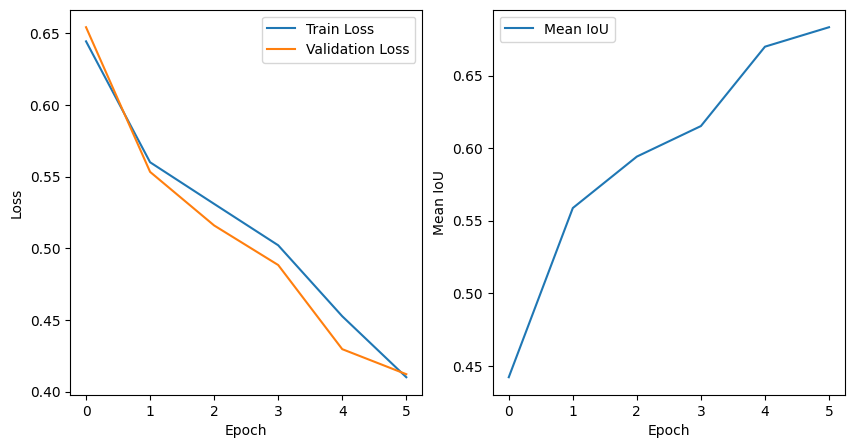

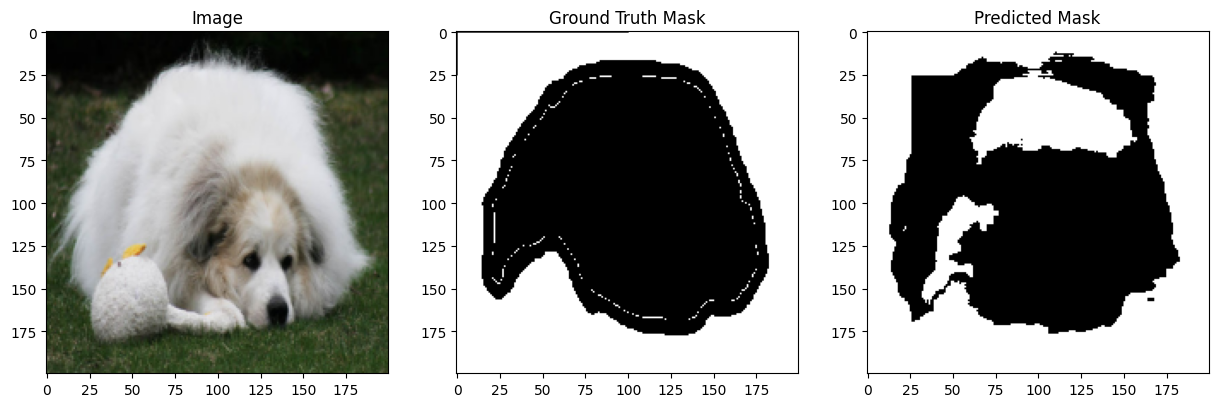

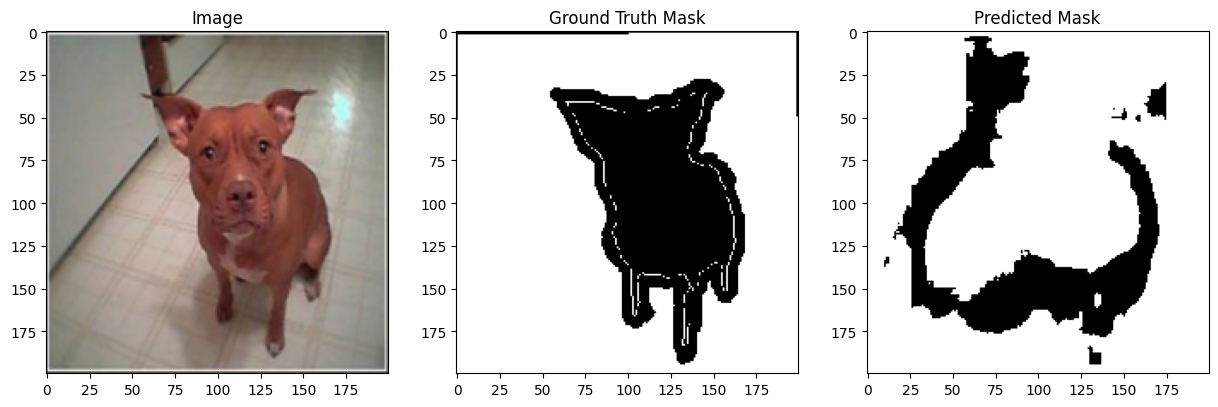

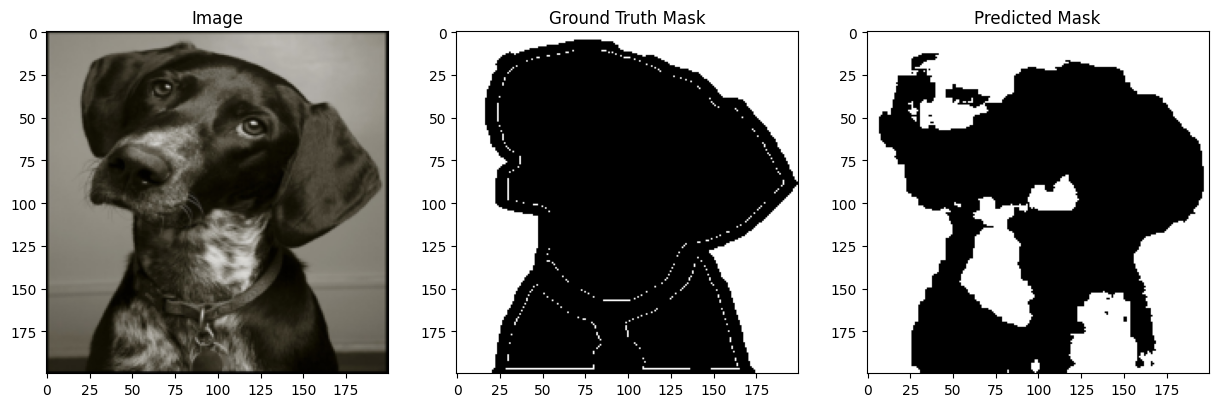

Test Loss: 0.4004
Mean IoU: 0.6843


In [13]:
uNetModel = UNet()
trained_model = train_model(uNetModel, train_loader, val_loader)
tested_model = test_model(uNetModel, test_loader)

# Part 2

### 2.1

Display image with bounding box drawn 

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])


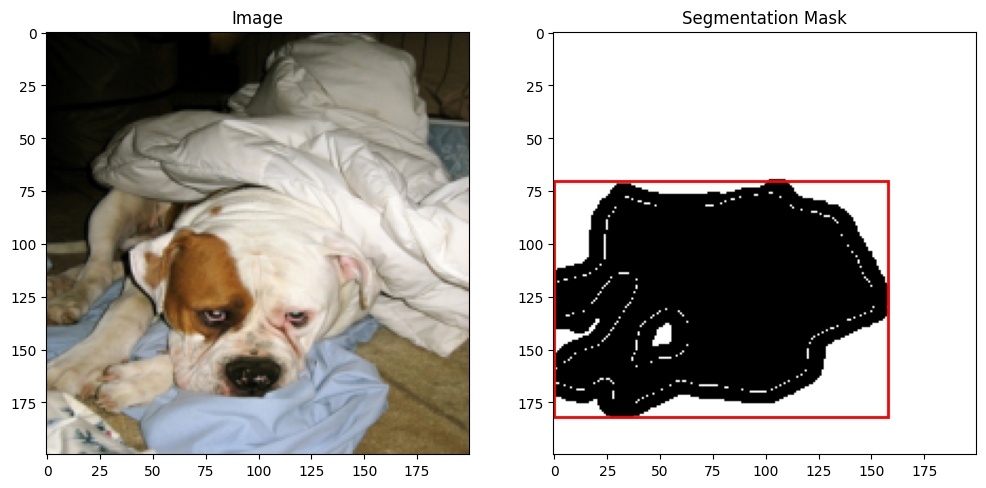

Image shape: torch.Size([3, 200, 200])
Mask shape: torch.Size([200, 200])
Label: 1


In [34]:
for images, mask, label, bounding_box in train_loader:
    img = images[0]
    mask = mask[0]
    
    print(mask)
    xmin, ymin, xmax, ymax = bounding_box[0]


    # Display the image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img.permute(1, 2, 0)) 
    plt.title("Image")

    # Display the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray") 
    plt.title("Segmentation Mask")
    
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='red', facecolor='none'))
    
    plt.show()
    
    print(f"Image shape: {img.shape}")
    print(f"Mask shape: {mask.shape}")
    print(f"Label: {label[0]}")
    break  # Display only one batch

### 2.2

pretrained yolov3 model

PRO TIP  Replace 'model=yolov3.pt' with new 'model=yolov3u.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


image 1/1 c:\Users\Devin\Documents\Code\cs512-f24-liu-devin\AS4\oxfordiiitpet\oxford-iiit-pet\images\Bombay_98.jpg: 640x512 1 cat, 712.3ms
Speed: 1.0ms preprocess, 712.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


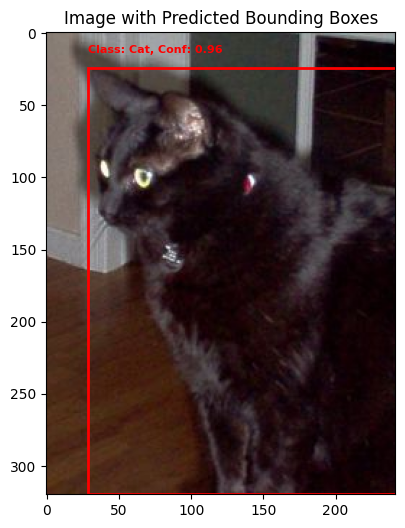

Predictions:
Class: Cat, Confidence: 0.96, BBox: [28.84790802001953, 23.951080322265625, 242.0, 319.45928955078125]


In [35]:
from PIL import Image

# Load pretrained YOLOv3 model
model = YOLO('yolov3.pt')  
results = model.predict(source='oxfordiiitpet/oxford-iiit-pet/images/Bombay_98.jpg', conf=0.5, save=False, max_det=1, device='cpu')

# Load the image
image_path = results[0].path
img = Image.open(image_path)

# Resize and normalize the image to 416x416
transform = transforms.Compose([
    transforms.Resize((416, 416)), 
    transforms.ToTensor(),          
])

img_transformed = transform(img)  

# Display the image and predictions

plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.title("Image with Predicted Bounding Boxes")


for box in results[0].boxes:
    xmin, ymin, xmax, ymax = box.xyxy[0].tolist()  
    cls = int(box.cls)  
    cls = "Dog" if cls == 16 else "Cat" # apparently yolov3 uses 16 for dog, 15 for cat
    conf = float(box.conf)  

    # Draw the bounding box
    plt.gca().add_patch(
        plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='red', facecolor='none')
    )


    plt.text(xmin, ymin - 10, f"Class: {cls}, Conf: {conf:.2f}", color='red', fontsize=8, weight='bold')

plt.show()


print("Predictions:")
for box in results[0].boxes:
    cls = int(box.cls) 
    cls = "Dog" if cls == 16 else "Cat" 
    conf = float(box.conf)  
    xmin, ymin, xmax, ymax = box.xyxy[0].tolist() 
    print(f"Class: {cls}, Confidence: {conf:.2f}, BBox: [{xmin}, {ymin}, {xmax}, {ymax}]")


### 2.4


Calculating mAP scores using the Ground Truth and Prediction Label txt files provided in the HW

In [36]:
from sklearn.metrics import precision_recall_curve, auc

def parse_files(truth_file_path, pred_file_path, class_id=0):
    truth_data = []
    pred_data = []
    
    # Parse ground truth file
    with open(truth_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            image_name = parts[0]
            bbox_data = list(map(int, parts[1].split(',')))  
            if bbox_data[-1] == class_id:  # check if class matches (0 for cat, 1 for dog)
                bbox = bbox_data[:4]  
                truth_data.append((image_name, bbox))

    # parse prediction file
    with open(pred_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            image_name = parts[0]
            bbox_data = list(map(float, parts[1].split(',')))  
            if int(bbox_data[4]) == class_id:  
                bbox = bbox_data[:4] 
                confidence = bbox_data[5]  
                pred_data.append((image_name, bbox, confidence))
    
    return truth_data, pred_data


def calculate_iou(box1, box2):
    x1, y1, x2, y2 = max(box1[0], box2[0]), max(box1[1], box2[1]), min(box1[2], box2[2]), min(box1[3], box2[3])
    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union = box1_area + box2_area - intersection
    return intersection / union


def calculate_ap(pred_boxes, truth_boxes, iou_thresholds):
    y_true, y_scores = [], []
    for image_name, pred_box, score in pred_boxes:
        y_scores.append(score)
        
        # check if there is any ground truth box with IoU > threshold (True Positive)
        match_found = any(calculate_iou(pred_box, truth_box) > iou_thresholds for truth_name, truth_box in truth_boxes if truth_name == image_name)
        
        if match_found:
            y_true.append(1)  # true positive
        else:
            y_true.append(0)  # false positive
            
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)


cat_truth_boxes, cat_predictions = parse_files('gt_label.txt', 'pred_label.txt', class_id=0)
dog_truth_boxes, dog_predictions = parse_files('gt_label.txt', 'pred_label.txt', class_id=1)

for threshold in [0.25, 0.5, 0.75, 0.95]:

    ap_cat = calculate_ap(cat_predictions, cat_truth_boxes, threshold)
    ap_dog = calculate_ap(dog_predictions, dog_truth_boxes, threshold)

    # calculate mAP
    map_score = (ap_cat + ap_dog) / 2
    print(f"Mean Average Precision (mAP) at threshold {threshold}: {map_score}")


Mean Average Precision (mAP) at threshold 0.25: 0.9978610159898593
Mean Average Precision (mAP) at threshold 0.5: 0.9862746451501958
Mean Average Precision (mAP) at threshold 0.75: 0.9034684717616172
Mean Average Precision (mAP) at threshold 0.95: 0.05293605470857083
